In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

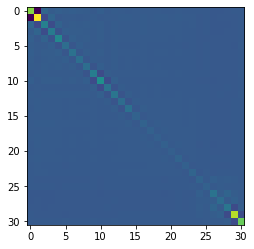

In [4]:
plt.imshow(syscov)

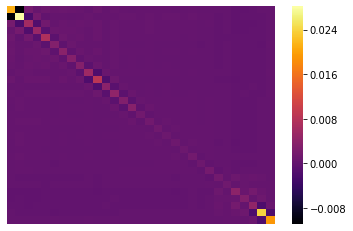

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [6]:
np.min(np.abs(syscov)), np.max(np.abs(syscov)) #checking non-negatives in the diagonal

(1.695011341e-07, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [7]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.05 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 1000 matrix 

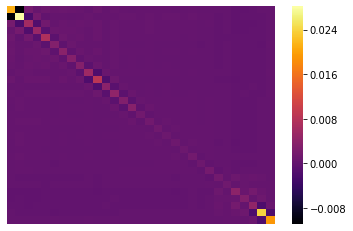

In [8]:
val, vec = np.linalg.eigh(syscov)
D = np.diag(val)
new = (vec+0.1) @ (D) @ (vec+0.1).T
sns.heatmap(pd.DataFrame(syscov), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

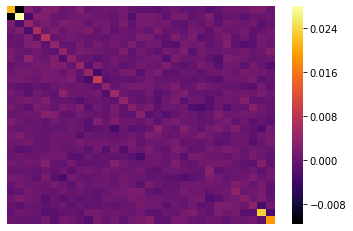

In [9]:
sns.heatmap(pd.DataFrame(covset[10]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [10]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


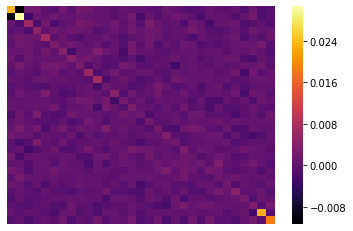

In [11]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [12]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)               

In [13]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/500
25/25 [==============================] - 0s 6ms/step - loss: 8.5428e-04 - val_loss: 6.8234e-05
Epoch 2/500
25/25 [==============================] - 0s 2ms/step - loss: 1.9049e-04 - val_loss: 2.0925e-05
Epoch 3/500
25/25 [==============================] - 0s 2ms/step - loss: 9.6226e-05 - val_loss: 1.0616e-05
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 6.4930e-05 - val_loss: 6.9504e-06
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 4.7083e-05 - val_loss: 4.9627e-06
Epoch 6/500
25/25 [==============================] - 0s 2ms/step - loss: 3.6287e-05 - val_loss: 3.7331e-06
Epoch 7/500
25/25 [==============================] - 0s 2ms/step - loss: 2.9738e-05 - val_loss: 3.0204e-06
Epoch 8/500
25/25 [==============================] - 0s 2ms/step - loss: 2.4511e-05 - val_loss: 2.6210e-06
Epoch 9/500
25/25 [==============================] - 0s 2ms/step - loss: 2.0625e-05 - val_loss: 2.2400e-06
Epoch 10/500
25/25 [=================

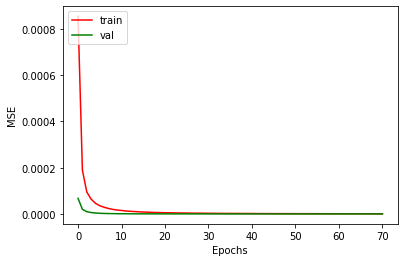

In [15]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [16]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

1.0357391602155987e-06 1.6187223081942648e-06


In [17]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(200, 31)


(200, 961)


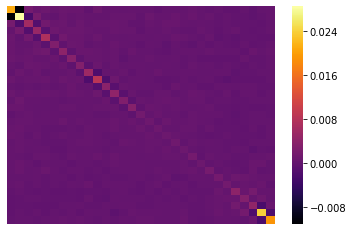

In [18]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


In [19]:
print(np.shape(decoded_imgs))

(200, 961)


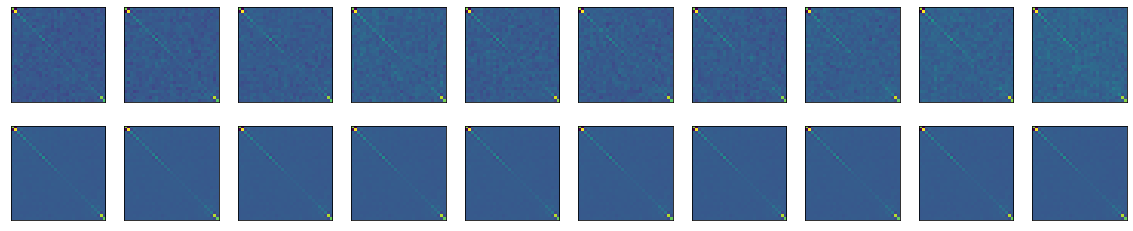

In [20]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

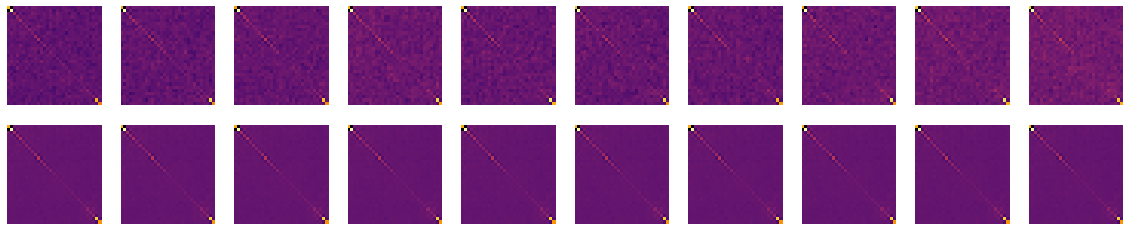

In [21]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

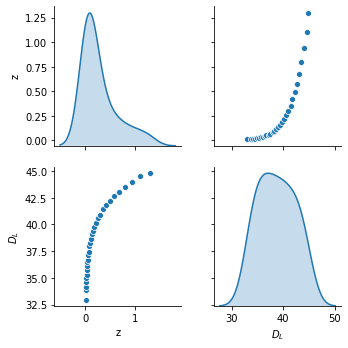

In [22]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
# print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [23]:
shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

In [24]:
z = data[:,0]
dl = data[:,1:]

In [25]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [26]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)

In [27]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=20,
                                   restore_best_weights=True)]

In [87]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(50, activation='relu')(efirst)
    x = Dense(50, activation='relu')(x)
    x = Dense(30, activation='relu')(x)

    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 1
epochs = 300
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                100       
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_24 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_25 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 31        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
___________________________________________________

In [88]:
model_train = neural_model.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/300
24/24 [==============================] - 0s 4ms/step - loss: 1398.8105 - val_loss: 1679.5458
Epoch 2/300
24/24 [==============================] - 0s 1ms/step - loss: 1217.2306 - val_loss: 1447.6718
Epoch 3/300
24/24 [==============================] - 0s 1ms/step - loss: 697.4900 - val_loss: 795.5377
Epoch 4/300
24/24 [==============================] - 0s 1ms/step - loss: 190.9980 - val_loss: 332.7084
Epoch 5/300
24/24 [==============================] - 0s 1ms/step - loss: 108.8984 - val_loss: 213.5470
Epoch 6/300
24/24 [==============================] - 0s 1ms/step - loss: 97.4660 - val_loss: 179.7361
Epoch 7/300
24/24 [==============================] - 0s 1ms/step - loss: 71.8788 - val_loss: 129.1994
Epoch 8/300
24/24 [==============================] - 0s 1ms/step - loss: 55.8800 - val_loss: 110.2025
Epoch 9/300
24/24 [==============================] - 0s 1ms/step - loss: 56.0322 - val_loss: 92.8062
Epoch 10/300
24/24 [==============================] - 0s 1ms/step - loss: 

24/24 [==============================] - 0s 1ms/step - loss: 0.4830 - val_loss: 0.2028
Epoch 83/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6494 - val_loss: 0.4235
Epoch 84/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6787 - val_loss: 0.6495
Epoch 85/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5391 - val_loss: 0.2249
Epoch 86/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7464 - val_loss: 0.6923
Epoch 87/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5634 - val_loss: 0.3562
Epoch 88/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3368 - val_loss: 0.1535
Epoch 89/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4496 - val_loss: 0.2096
Epoch 90/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6138 - val_loss: 0.1966
Epoch 91/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6518 - val_loss: 0.5616
Epoch 92/300


24/24 [==============================] - 0s 1000us/step - loss: 0.2979 - val_loss: 0.1087
Epoch 164/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7482 - val_loss: 1.1212
Epoch 165/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7203 - val_loss: 0.1887
Epoch 166/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3885 - val_loss: 2.0209
Epoch 167/300
24/24 [==============================] - 0s 997us/step - loss: 1.0288 - val_loss: 2.0982
Epoch 168/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4180 - val_loss: 2.3155
Epoch 169/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6362 - val_loss: 0.4132
Epoch 170/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6447 - val_loss: 0.0984
Epoch 171/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2641 - val_loss: 0.0950
Epoch 172/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1771 - val_loss: 1.0938

24/24 [==============================] - 0s 1ms/step - loss: 0.3871 - val_loss: 0.0686
Epoch 245/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1974 - val_loss: 0.2839
Epoch 246/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1616 - val_loss: 0.6021
Epoch 247/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1797 - val_loss: 0.0555
Epoch 248/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3128 - val_loss: 1.0540
Epoch 249/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3181 - val_loss: 0.8307
Epoch 250/300
24/24 [==============================] - 0s 1ms/step - loss: 0.4327 - val_loss: 0.2144
Epoch 251/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2846 - val_loss: 0.3632
Epoch 252/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2432 - val_loss: 0.0490
Epoch 253/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1059 - val_loss: 0.0394
Epoc

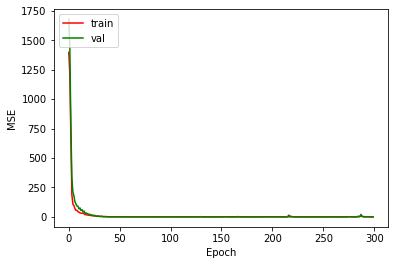

In [89]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [90]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet, np.min(model_train.history['loss']), np.min(model_train.history['val_loss'])

(0.1800187623325319, 0.08728891611099243, 0.0324067547917366)

In [91]:
# pred = neural_model.predict(z_test)
# pred

In [92]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z), 31)
ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranzz)
# pred_random

In [93]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [94]:
fake_encoded = np.zeros((1, 31))

In [95]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))


(1, 31)
(31,)
(200, 31)


In [96]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]

In [97]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake), np.shape(fake_encoded)

((1, 961), (1, 31))

In [98]:
# decoded_fake[0, :]

1.8771243e-07

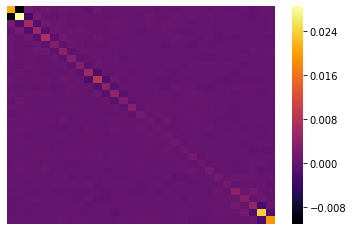

In [99]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

-0.01084098704 0.02815552265 0.00039265133851975654
-0.010955981 0.02841785 0.00039208186
-0.010957444 0.028413167 0.00039184775


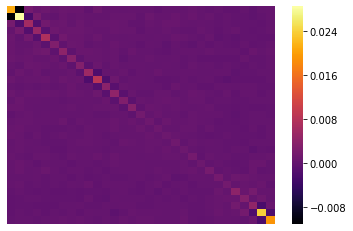

In [100]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal
print(np.min(clean_img[0,:]), np.max(clean_img[0,:]), np.mean(clean_img[0,:])) #checking non-negatives in the diagonal



In [101]:
np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLA_COVdecodedclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [102]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
#             print(i,j, end=' ')
#             print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

465

In [103]:
np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", header="#fake COV")

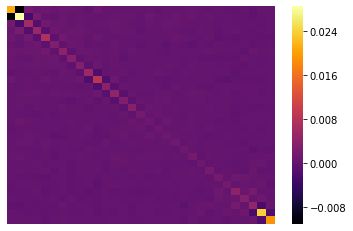

In [104]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [105]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)
np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")

In [106]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
np.max(errors), np.max(fakeerrors)

(0.1677960745965173, 0.16857594)

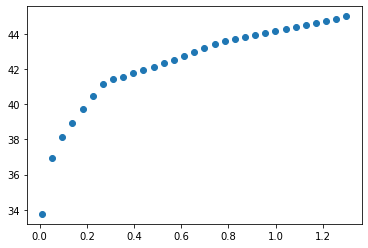

In [107]:
plt.scatter(ranz, pred_random)

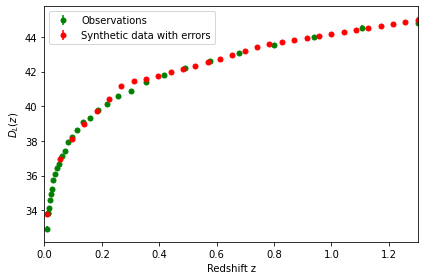

In [108]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
# plt.savefig('fake_vs_binned_jla.png', dpi=200)

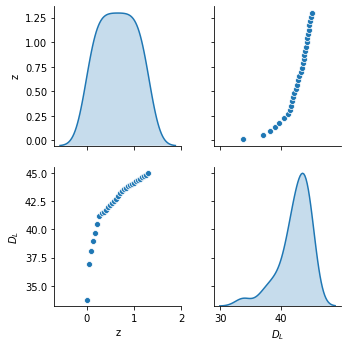

In [109]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')

### NOW we use dropout as uncertainty estimator

In [51]:
from astroNN.nn.layers import MCDropout

In [52]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))
# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.2)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.2)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.2)(encoded2)
#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.2)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
# x2 = MCDropout(0.2)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               96200     
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 31)                3131      
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)               

In [53]:
batch_size = 4
# optimizer = Adam(lr=.005)
# optimizer = Adam(lr=0.0001)


autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test),
                    callbacks=callbacks)

Epoch 1/500
25/25 [==============================] - 0s 6ms/step - loss: 6.7293e-04 - val_loss: 2.4553e-04
Epoch 2/500
25/25 [==============================] - 0s 2ms/step - loss: 1.3587e-04 - val_loss: 1.0242e-04
Epoch 3/500
25/25 [==============================] - 0s 2ms/step - loss: 6.6055e-05 - val_loss: 6.4677e-05
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 4.3990e-05 - val_loss: 4.6861e-05
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 3.2455e-05 - val_loss: 3.6354e-05
Epoch 6/500
25/25 [==============================] - 0s 2ms/step - loss: 2.5577e-05 - val_loss: 2.8436e-05
Epoch 7/500
25/25 [==============================] - 0s 2ms/step - loss: 1.9966e-05 - val_loss: 2.4010e-05
Epoch 8/500
25/25 [==============================] - 0s 2ms/step - loss: 1.6569e-05 - val_loss: 2.0558e-05
Epoch 9/500
25/25 [==============================] - 0s 2ms/step - loss: 1.4291e-05 - val_loss: 1.7464e-05
Epoch 10/500
25/25 [=================

Epoch 77/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2912e-06 - val_loss: 1.4226e-06
Epoch 78/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2774e-06 - val_loss: 1.4407e-06
Epoch 79/500
25/25 [==============================] - 0s 2ms/step - loss: 1.2719e-06 - val_loss: 1.4227e-06
Epoch 80/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2736e-06 - val_loss: 1.4188e-06
Epoch 81/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2612e-06 - val_loss: 1.4059e-06
Epoch 82/500
25/25 [==============================] - 0s 2ms/step - loss: 1.2531e-06 - val_loss: 1.4077e-06
Epoch 83/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2471e-06 - val_loss: 1.3668e-06
Epoch 84/500
25/25 [==============================] - 0s 3ms/step - loss: 1.2397e-06 - val_loss: 1.3791e-06
Epoch 85/500
25/25 [==============================] - 0s 2ms/step - loss: 1.2374e-06 - val_loss: 1.3594e-06
Epoch 86/500
25/25 [========

25/25 [==============================] - 0s 2ms/step - loss: 1.0899e-06 - val_loss: 1.1288e-06
Epoch 153/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0896e-06 - val_loss: 1.1192e-06
Epoch 154/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0918e-06 - val_loss: 1.1186e-06
Epoch 155/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0913e-06 - val_loss: 1.1241e-06
Epoch 156/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0899e-06 - val_loss: 1.1212e-06
Epoch 157/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0872e-06 - val_loss: 1.1229e-06
Epoch 158/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0851e-06 - val_loss: 1.1142e-06
Epoch 159/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0843e-06 - val_loss: 1.1216e-06
Epoch 160/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0860e-06 - val_loss: 1.1152e-06
Epoch 161/500
25/25 [============

25/25 [==============================] - 0s 2ms/step - loss: 1.0666e-06 - val_loss: 1.0771e-06
Epoch 228/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0639e-06 - val_loss: 1.0769e-06
Epoch 229/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0656e-06 - val_loss: 1.0784e-06
Epoch 230/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0665e-06 - val_loss: 1.0767e-06
Epoch 231/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0636e-06 - val_loss: 1.0754e-06
Epoch 232/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0622e-06 - val_loss: 1.0801e-06
Epoch 233/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0665e-06 - val_loss: 1.0825e-06
Epoch 234/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0635e-06 - val_loss: 1.0753e-06
Epoch 235/500
25/25 [==============================] - 0s 2ms/step - loss: 1.0637e-06 - val_loss: 1.0808e-06
Epoch 236/500
25/25 [============

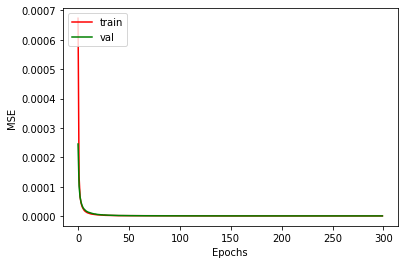

In [54]:
plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLAdropout.png', dpi=200)

In [55]:
encoder2 = tf.keras.Model(input_img2, encoded2)
# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [56]:
decoder2.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 31)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               3200      
_________________________________________________________________
MCDropout_4 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
_______________________________________________

In [57]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
print(np.shape(fake_encoded))
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0)
std_mc_dropout_dec = np.std(predictions_dec, axis=0)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(1, 31)


((1, 961), (1, 961))

In [58]:
np.mean(std_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(9.250229774667488e-06, (1, 961))

In [59]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.02)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.02)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.02)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.02)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 4
epochs = 400
input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                100       
_________________________________________________________________
MCDropout_5 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_6 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
MCDropout_7 (MCDropout)      (None, 50)              

In [60]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test))

Epoch 1/400
6/6 [==============================] - 0s 17ms/step - loss: 1438.4835 - val_loss: 1739.4805
Epoch 2/400
6/6 [==============================] - 0s 2ms/step - loss: 1428.0635 - val_loss: 1724.9193
Epoch 3/400
6/6 [==============================] - 0s 2ms/step - loss: 1413.5679 - val_loss: 1710.2373
Epoch 4/400
6/6 [==============================] - 0s 2ms/step - loss: 1394.1465 - val_loss: 1689.7799
Epoch 5/400
6/6 [==============================] - 0s 2ms/step - loss: 1365.8462 - val_loss: 1659.6354
Epoch 6/400
6/6 [==============================] - 0s 2ms/step - loss: 1323.4076 - val_loss: 1607.1565
Epoch 7/400
6/6 [==============================] - 0s 2ms/step - loss: 1270.0851 - val_loss: 1542.9855
Epoch 8/400
6/6 [==============================] - 0s 2ms/step - loss: 1182.7758 - val_loss: 1449.4138
Epoch 9/400
6/6 [==============================] - 0s 2ms/step - loss: 1079.1957 - val_loss: 1319.4623
Epoch 10/400
6/6 [==============================] - 0s 2ms/step - loss: 

6/6 [==============================] - 0s 2ms/step - loss: 8.8165 - val_loss: 7.8801
Epoch 83/400
6/6 [==============================] - 0s 2ms/step - loss: 9.3861 - val_loss: 5.9582
Epoch 84/400
6/6 [==============================] - 0s 2ms/step - loss: 14.3136 - val_loss: 12.6785
Epoch 85/400
6/6 [==============================] - 0s 3ms/step - loss: 9.7499 - val_loss: 18.9687
Epoch 86/400
6/6 [==============================] - 0s 2ms/step - loss: 7.6309 - val_loss: 5.2235
Epoch 87/400
6/6 [==============================] - 0s 2ms/step - loss: 8.4717 - val_loss: 16.6717
Epoch 88/400
6/6 [==============================] - 0s 2ms/step - loss: 4.2620 - val_loss: 15.4203
Epoch 89/400
6/6 [==============================] - 0s 3ms/step - loss: 3.2501 - val_loss: 2.4672
Epoch 90/400
6/6 [==============================] - 0s 3ms/step - loss: 6.2885 - val_loss: 6.9425
Epoch 91/400
6/6 [==============================] - 0s 3ms/step - loss: 5.0054 - val_loss: 5.5466
Epoch 92/400
6/6 [==========

6/6 [==============================] - 0s 2ms/step - loss: 8.2589 - val_loss: 3.8328
Epoch 165/400
6/6 [==============================] - 0s 3ms/step - loss: 8.2827 - val_loss: 5.7676
Epoch 166/400
6/6 [==============================] - 0s 2ms/step - loss: 13.5026 - val_loss: 9.1320
Epoch 167/400
6/6 [==============================] - 0s 2ms/step - loss: 8.9093 - val_loss: 15.6998
Epoch 168/400
6/6 [==============================] - 0s 2ms/step - loss: 14.4317 - val_loss: 9.9407
Epoch 169/400
6/6 [==============================] - 0s 2ms/step - loss: 7.8175 - val_loss: 5.6139
Epoch 170/400
6/6 [==============================] - 0s 2ms/step - loss: 13.5293 - val_loss: 5.5744
Epoch 171/400
6/6 [==============================] - 0s 2ms/step - loss: 7.9479 - val_loss: 8.9672
Epoch 172/400
6/6 [==============================] - 0s 2ms/step - loss: 10.7680 - val_loss: 12.6370
Epoch 173/400
6/6 [==============================] - 0s 2ms/step - loss: 6.2804 - val_loss: 6.5912
Epoch 174/400
6/6 

6/6 [==============================] - 0s 3ms/step - loss: 6.6061 - val_loss: 12.9367
Epoch 247/400
6/6 [==============================] - 0s 2ms/step - loss: 4.9333 - val_loss: 2.3667
Epoch 248/400
6/6 [==============================] - 0s 2ms/step - loss: 3.7205 - val_loss: 2.5716
Epoch 249/400
6/6 [==============================] - 0s 2ms/step - loss: 3.6020 - val_loss: 1.3205
Epoch 250/400
6/6 [==============================] - 0s 2ms/step - loss: 7.6998 - val_loss: 4.6730
Epoch 251/400
6/6 [==============================] - 0s 2ms/step - loss: 4.2308 - val_loss: 4.0433
Epoch 252/400
6/6 [==============================] - 0s 2ms/step - loss: 8.0464 - val_loss: 11.4051
Epoch 253/400
6/6 [==============================] - 0s 2ms/step - loss: 7.6471 - val_loss: 6.9420
Epoch 254/400
6/6 [==============================] - 0s 2ms/step - loss: 8.0920 - val_loss: 4.7753
Epoch 255/400
6/6 [==============================] - 0s 2ms/step - loss: 7.1672 - val_loss: 5.4582
Epoch 256/400
6/6 [===

6/6 [==============================] - 0s 2ms/step - loss: 13.1954 - val_loss: 14.1612
Epoch 329/400
6/6 [==============================] - 0s 2ms/step - loss: 5.2596 - val_loss: 11.4001
Epoch 330/400
6/6 [==============================] - 0s 3ms/step - loss: 5.2311 - val_loss: 11.5143
Epoch 331/400
6/6 [==============================] - 0s 2ms/step - loss: 4.0149 - val_loss: 10.5243
Epoch 332/400
6/6 [==============================] - 0s 2ms/step - loss: 7.0944 - val_loss: 4.0833
Epoch 333/400
6/6 [==============================] - 0s 2ms/step - loss: 5.0325 - val_loss: 18.6149
Epoch 334/400
6/6 [==============================] - 0s 2ms/step - loss: 5.4994 - val_loss: 9.6754
Epoch 335/400
6/6 [==============================] - 0s 3ms/step - loss: 17.5690 - val_loss: 4.4251
Epoch 336/400
6/6 [==============================] - 0s 2ms/step - loss: 9.4428 - val_loss: 7.4777
Epoch 337/400
6/6 [==============================] - 0s 2ms/step - loss: 14.6100 - val_loss: 5.1158
Epoch 338/400
6/

In [117]:
# Generate test data
test_batch_size = 31
x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)

mc_dropout_num = 50  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
#     print(predictions[i])

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

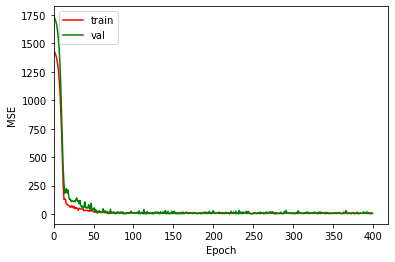

In [119]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_dropoutJLA.png', dpi=100)

In [120]:
np.mean(std_mc_dropout)

2.7471862818435855

In [121]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [122]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

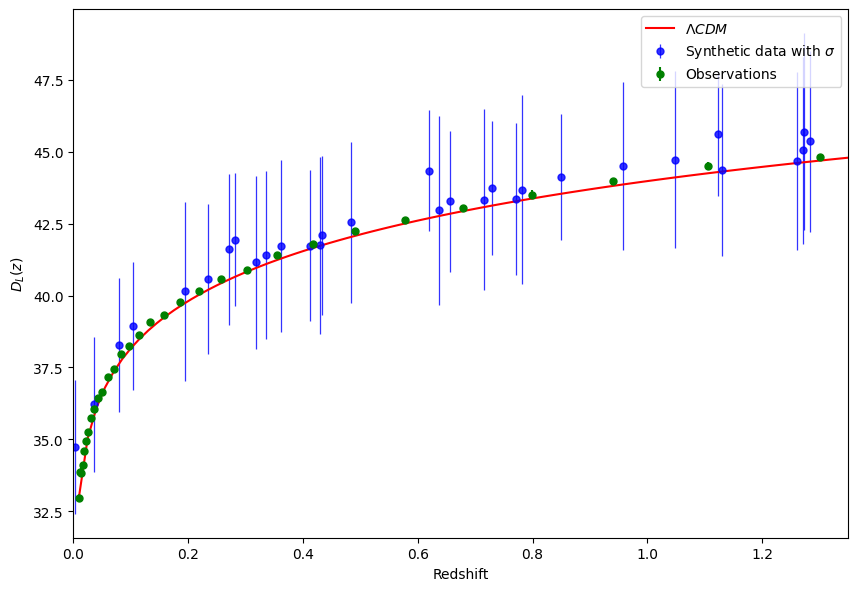

In [123]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))

sigma = np.sqrt(std_mc_dropout.reshape(31,)**2 + fakeerrors2 + std_dropout_diag**2)

plt.errorbar(x_test, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift')
plt.ylabel('$D_L(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=200)

In [124]:
np.savetxt("fake_binned_JLA_COVdecodedDO.dat", prediction_mc_dropout_dec[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [86]:
x_test

array([0.01 , 0.053, 0.096, 0.139, 0.182, 0.225, 0.268, 0.311, 0.354,
       0.397, 0.44 , 0.483, 0.526, 0.569, 0.612, 0.655, 0.698, 0.741,
       0.784, 0.827, 0.87 , 0.913, 0.956, 0.999, 1.042, 1.085, 1.128,
       1.171, 1.214, 1.257, 1.3  ])

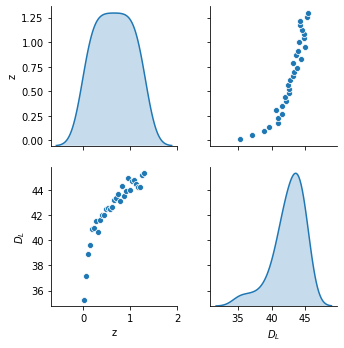

In [110]:
fake_datadf2 = pd.DataFrame(fake_data2, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf2, diag_kind="kde")
plt.savefig('fake_binned_jla22DO.png')

In [115]:
clean_img = autoencoder2.predict(prediction_mc_dropout_dec[0, :].reshape(1,-1))

In [116]:
np.savetxt("fake_binned_JLA_COVdecodedDO.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")